In [1]:
import functools

import jax
import jax.numpy as jnp
from jax_spe import spe
import numpy as np
import matplotlib.pyplot as plt
from flax import nn

In [2]:
jax.config.update('jax_platform_name', 'cpu')

In [3]:
# number of layers to simulate
# n_layers = 8

# dimension for the keys and queries
keys_dim = 64
num_heads = 8
num_realizations = 64
num_sines = 10

In [4]:
class Encoder(nn.Module):

    def apply(self, rng_key, q, k):
        qbar, kbar = spe.SineSPE(
            rng_key, q.shape,
            num_sines=num_sines,
            num_realizations=num_realizations)
        qbar, kbar = spe.SPEGate(rng_key, (qbar, kbar))
        return spe.apply_spe(q, qbar), spe.apply_spe(k, kbar)

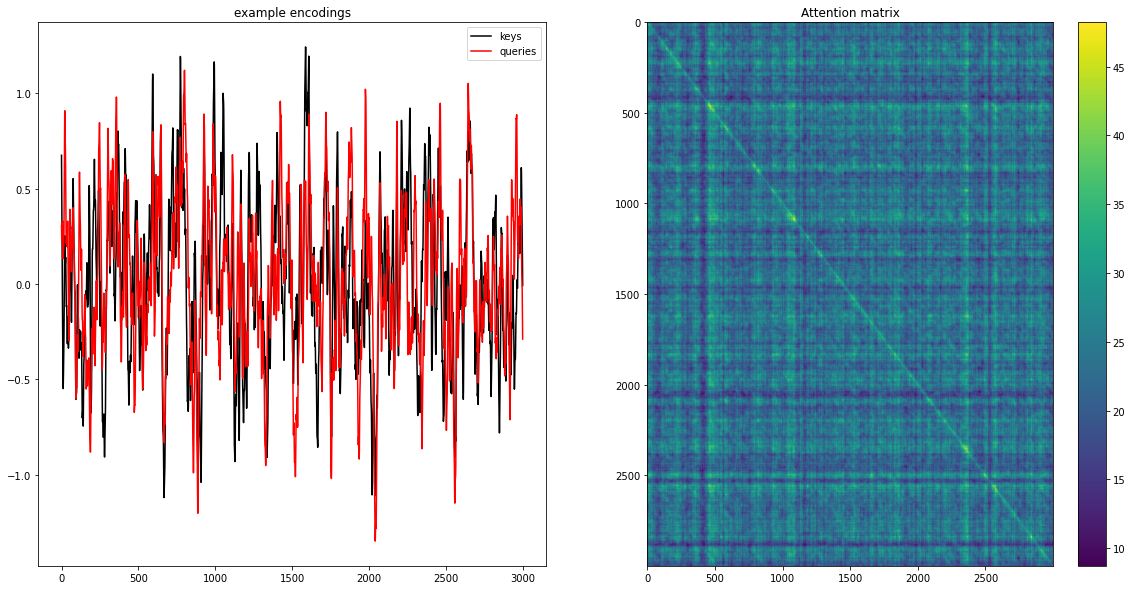

In [5]:
n = 3000
batchsize=16

# generate some keys and queries of shape (batchsize, num, n)
q = jnp.ones((batchsize, n, num_heads, keys_dim))
k = jnp.ones((batchsize, n, num_heads, keys_dim))

_, params = Encoder.init(jax.random.PRNGKey(0), jax.random.PRNGKey(0), q, k)

#params['SPEGate_1']['gate'] = params['SPEGate_1']['gate'] + 2.

@jax.jit
def encode(q, k):
    return Encoder.call(params, jax.random.PRNGKey(1), q, k)

q, k = encode(q, k)

A = q[0,:,0,:] @ k[0,:,0,:].T

plt.figure(figsize=[20,10]);
plt.subplot(121)
plt.plot(k[0,:,0,0],'k');
plt.plot(q[0,:,0,0],'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(122);
plt.imshow(A, aspect='auto', interpolation='nearest');
plt.title('Attention matrix');
plt.colorbar();
